Importing Libraries and uploading dataset

In [1]:
import numpy as np
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram

np.random.seed(555)
movies_df = pd.read_csv(r'./datasets/movies.csv')
print("Number of movies loaded: {} ".format(len(movies_df)))

# Combine wiki_plot and imdb_plot into a single column
movies_df['plot'] = movies_df['wiki_plot'].astype(str) + "\n" +  movies_df['imdb_plot'].astype(str)
display(movies_df.head())

Number of movies loaded: 100 


,rank,title,genre,wiki_plot,imdb_plot,plot
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t...","On the day of his only daughter's wedding, Vit..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker...","In 1947, banker Andy Dufresne is convicted of ..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...,"In 1939, the Germans move Polish Jews into the..."
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat...","In a brief scene in 1964, an aging, overweight..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1...",It is early December 1941. American expatriate...


Loading language model and defining function for Tokenization and Lemmatization.

In [2]:
nlp = spacy.load('en_core_web_md')

def spacy_processing(text):
    doc = nlp(text)
    # Return a list of lemmatized tokens
    return [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

Creating Tf-idf Vectorizer with defined tokenizer and lemmatizer function.

In [3]:
# Create TfidfVectorizer with spaCy tokenizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=spacy_processing, max_df=0.8, min_df= 0.2, use_idf=True,ngram_range=(1,3))
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_df['plot'])
print(tfidf_matrix.shape)

c:\Users\Gabriel\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(100, 494)


Defining the Cosine Similarity and Similarity Distances matrices.

In [4]:
cosine_sim_matrix = cosine_similarity(tfidf_matrix)
similarity_distance = 1 - cosine_sim_matrix

Defining the number of clusters with the Elbow method.  
In this case there isn't a distinct elbow, which makes it challenging to pinpoint the optimal number of clusters. I have selected 6 clusters as it provides a balance that captures a diverse range of movie genres effectively. 

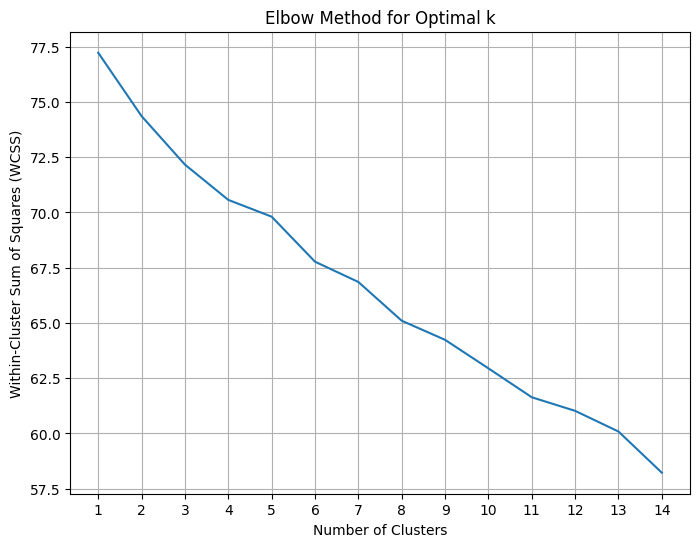

In [5]:
k_range = range(1, 15)
wcss = []
# Fit K-Means for each k and calculate WCSS (WCSS is the sum of squared distances of samples to their closest cluster center)
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=555)
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)  

sns.lineplot(x=k_range, y=wcss).set(title='Elbow Method for Optimal k', xlabel='Number of Clusters', ylabel='Within-Cluster Sum of Squares (WCSS)', xticks=k_range)
plt.gcf().set_size_inches(8, 6) 
plt.grid(True)
plt.show()

In [6]:
km = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=555)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

# Create a column cluster to denote the generated cluster for each movie
movies_df["cluster"] = clusters
# Display number of films per cluster 
movies_df['cluster'].value_counts() 

cluster
1    33
5    22
2    18
0    13
3     9
4     5
Name: count, dtype: int64

Dendrograms help us understand the level of similarity between movies visually.  
Dendrograms help visualize the results of hierarchical clustering, which is an alternative to k-means clustering.  
(open image in a new tab for better exploration)

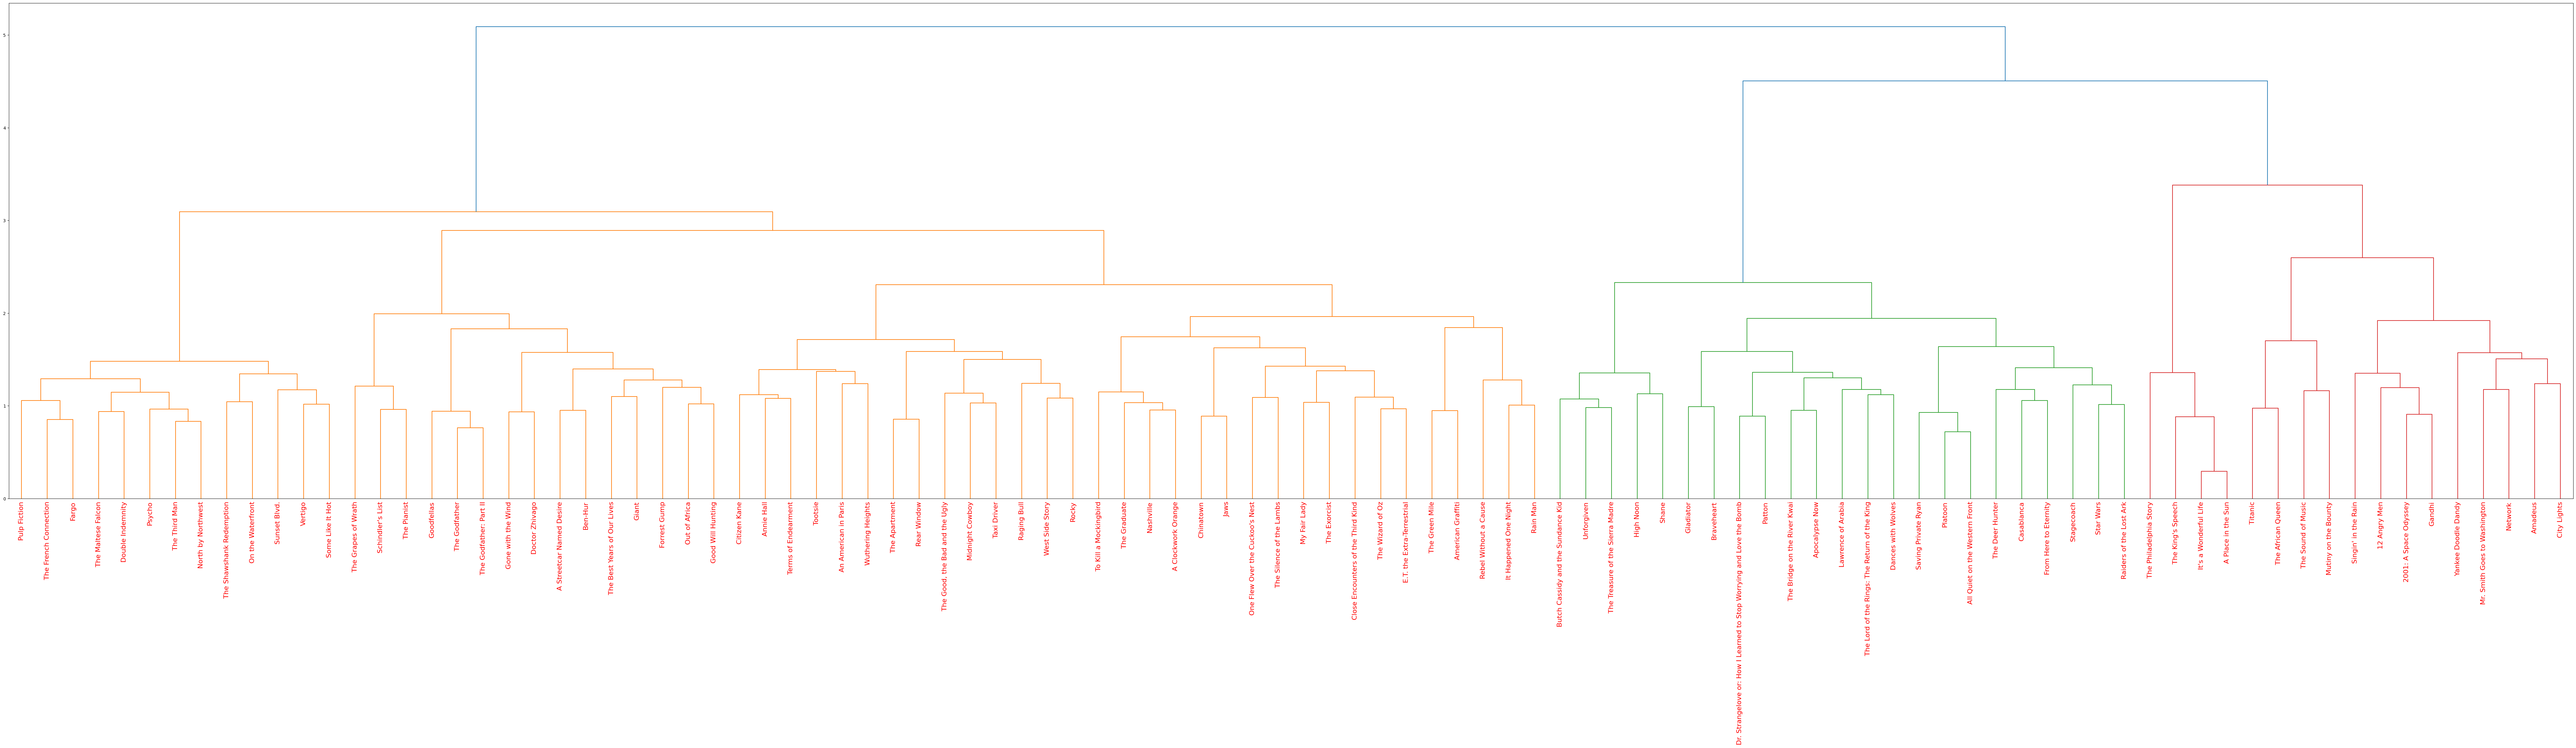

In [7]:
# Create mergings matrix 
mergings = linkage(similarity_distance, method='ward')
# Plot the dendrogram, using title as label column
dendrogram_ = dendrogram(mergings,
               labels=[x for x in movies_df["title"]],
               leaf_rotation=90,
               leaf_font_size=16,)

# Adjust the plot
fig = plt.gcf()
_ = [lbl.set_color('r') for lbl in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(108, 21)
plt.show()

Final Function Objective: to find the top 3 similar movies within the same cluster.

In [8]:
def top_3_recommendations(movie):
    # Get the index of the movie that matches the title
    idx = movies_df[movies_df['title'] == movie].index
    if idx.empty:
        return "Movie not found"
    idx = idx[0]
    cluster_number = movies_df['cluster'].iloc[idx]
    # Filter by movie cluster
    filtered_df = movies_df[movies_df['cluster'] == cluster_number]
    # Filter similarity distance matrix by cluster movies and sort by similarity score
    filtered_similarity_distance_matrix = pd.DataFrame(similarity_distance[filtered_df.index,idx], index=filtered_df.index).sort_values(by=0)
    print ("Recommended movies for: " + movie)
    for i in range(1, 4):
        recommended_movie = movies_df['title'].iloc[filtered_similarity_distance_matrix.index[i]]
        print(f"\t{recommended_movie}")
  

Example: Recommended movies for "Rocky"

In [9]:
top_3_recommendations('Rocky')

Recommended movies for: Rocky
	On the Waterfront
	Raging Bull
	West Side Story
